In [2]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import Compose
import torch
import torch.nn as nn
import sys
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm

In [9]:
from google.colab import drive
drive.mount('/content/drive')
project_path = '/content/drive/MyDrive/research_project'
os.chdir(project_path)

Mounted at /content/drive


In [10]:
base_path = '/content/drive/MyDrive/research_project'
data_path = '/content/drive/MyDrive/research_project/all_selected'

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

Model

In [5]:
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        # Shared MLP
        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_concat = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x_concat))

class CBAM(nn.Module):
    def __init__(self, channels, reduction=16):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(channels, reduction)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x

class ResNetFeatureExtractor(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNetFeatureExtractor, self).__init__()
        # Load pretrained ResNet50 with proper weights specification
        weights = models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None
        self.resnet = models.resnet50(weights=weights)
        # Remove the final fully connected layer
        self.features = nn.Sequential(*list(self.resnet.children())[:-2])

    def forward(self, x):
        return self.features(x)

class CBAMClassifier(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(CBAMClassifier, self).__init__()
        self.feature_extractor = ResNetFeatureExtractor(pretrained)
        self.cbam = CBAM(channels=2048)  # ResNet50 has 2048 channels in final layer
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(2048, num_classes)

        # Initialize the weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Handle grayscale input
        if x.size(1) == 1:
            x = x.repeat(1, 3, 1, 1)

        # Extract features
        x = self.feature_extractor(x)

        # Apply CBAM
        x = self.cbam(x)

        # Global pooling and classification
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

In [6]:
class CustomDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        #labels_tensor = torch.tensor(labels, dtype=torch.long)
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        # Open the image
        image = Image.open(file_path).convert('L')  # Convert to grayscale

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        return image, label

In [16]:
file_paths = []
labels = []
correct_labels = []
# Iterate through each folder (e.g., 'Selected_Frames_1-1')
for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)

    # Only consider directories that contain image subdirectories
    if os.path.isdir(folder_path):
        for subfolder in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder)

            # Only consider directories that contain .png files
            if os.path.isdir(subfolder_path):
                subfolder_parts = subfolder.split('_')

                # Ensure that the subfolder name has at least 5 parts (to extract correct label)
                if len(subfolder_parts) >= 5:
                    correct_label = int(subfolder_parts[4])  # Extract CorrectLabel from the 5th part
                    correct_labels.append(correct_label)

                    for file_name in os.listdir(subfolder_path):
                        if file_name.endswith('.png'):  # Only consider .png files
                            file_path = os.path.join(subfolder_path, file_name)
                            file_paths.append(file_path)
                            labels.append(correct_label - 1)  # Correct label is either 1 or 2, so subtract 1

# Print the first file path and label
print(f"file path: {file_paths[0]}")
print(f"label: {labels[:100]}")


file path: /content/drive/MyDrive/research_project/all_selected/Selected_Frames_3/301_18_1_9_1_stand/24372.png
label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [9]:
unique_labels = np.unique(correct_labels)
print(f"Number of unique labels: {len(unique_labels)}")
print(f"Unique labels: {unique_labels}")

Number of unique labels: 3
Unique labels: [1 2 3]


In [ ]:
print(len(file_paths))
print(len(labels))

25890
25890


ignoring where correct label is 3

In [17]:
# prompt: print only the last part of the file path where label is 2

import os

# Assuming 'file_paths' and 'labels' are defined as in your provided code.

for i, label in enumerate(labels):
    if label == 2:
        print((file_paths[i]))
        break # Assuming you only need the first instance where label is 2

/content/drive/MyDrive/research_project/all_selected/Selected_Frames_2-5/204_18_8_14_3_chair/20395.png


In [18]:
# prompt: remove from file_paths and the corresponding labels wherever the labels==2

# Assuming 'file_paths' and 'labels' are defined as in your provided code.

new_file_paths = []
new_labels = []

for i, label in enumerate(labels):
    if label != 2:
        new_file_paths.append(file_paths[i])
        new_labels.append(label)

file_paths = new_file_paths
labels = new_labels

In [19]:
unique_labels = np.unique(labels)
print(f"Number of unique labels: {len(unique_labels)}")
print(f"Unique labels: {unique_labels}")

Number of unique labels: 2
Unique labels: [0 1]


In [12]:
print(len(file_paths))
print(len(labels))

25770
25770


In [13]:
# prompt: print where label is 2

import pandas as pd

# Assuming 'labels' is defined as in your provided code
df = pd.DataFrame({'file_path': file_paths, 'label': labels})

# Print rows where label is 2
print(df[df['label'] == 2])

Empty DataFrame
Columns: [file_path, label]
Index: []


In [20]:
#60 training
train_files, temp_files, train_labels, temp_labels = train_test_split(file_paths, labels, test_size=0.4, random_state=42)
#splitting the 40 into 20 and 20
val_files, test_files, val_labels, test_labels = train_test_split(temp_files, temp_labels, test_size=0.5, random_state=42)


In [14]:
print(len(train_files))
print(len(train_labels))
print(len(val_files))
print(len(test_files))

15462
15462
5154
5154


In [21]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale images
])

# Create datasets
train_dataset = CustomDataset(train_files, train_labels, transform)
val_dataset = CustomDataset(val_files, val_labels, transform)
test_dataset = CustomDataset(test_files, test_labels, transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [16]:
import torch
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

GPU Available: True
GPU Memory: 15.83 GB


In [17]:
print("CUDA Version:", torch.version.cuda)
print("PyTorch Version:", torch.__version__)
print("Available GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

CUDA Version: 12.4
PyTorch Version: 2.5.1+cu124
Available GPU: Tesla T4


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2  # Binary classification
model = CBAMClassifier(num_classes=num_classes, pretrained=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 141MB/s]


Training

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []

    print(f"Using device: {device}")
    print("Starting training...")

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch + 1}")):
            try:
                # Move data to device
                images = images.to(device)
                labels = labels.to(device)

                # Clear gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                # Calculate statistics
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                if (batch_idx + 1) % 10 == 0:
                    print(f"  Batch {batch_idx + 1}/{len(train_loader)}: "
                          f"Loss = {loss.item():.4f}, "
                          f"Accuracy = {correct/total:.4f}")

            except RuntimeError as e:
                print(f"Error in batch {batch_idx}: {str(e)}")
                torch.cuda.empty_cache()  # Clear CUDA memory
                continue

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        print(f"Epoch {epoch + 1} completed. Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

        # Save checkpoint
        if (epoch + 1) % 5 == 0:
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': epoch_loss,
            }
            torch.save(checkpoint, f'checkpoint_epoch_{epoch+1}.pth')

    return train_loss, val_loss, train_acc, val_acc

In [19]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
train_loss, val_loss, train_acc, val_acc = train_model(model=model,
  train_loader=train_loader,
  val_loader=val_loader,
  criterion=criterion,
  optimizer=optimizer,
  num_epochs=10,
  device=device)

Using device: cuda
Starting training...

Epoch 1/10


Training Epoch 1:   8%|▊         | 10/121 [22:30<4:05:30, 132.70s/it]

  Batch 10/121: Loss = 0.3136, Accuracy = 0.7352


Training Epoch 1:  17%|█▋        | 20/121 [43:32<3:29:04, 124.20s/it]

  Batch 20/121: Loss = 0.3001, Accuracy = 0.7984


Training Epoch 1:  25%|██▍       | 30/121 [1:03:54<3:05:38, 122.40s/it]

  Batch 30/121: Loss = 0.2291, Accuracy = 0.8250


Training Epoch 1:  33%|███▎      | 40/121 [1:23:50<2:41:03, 119.31s/it]

  Batch 40/121: Loss = 0.2494, Accuracy = 0.8432


Training Epoch 1:  41%|████▏     | 50/121 [1:43:22<2:21:10, 119.31s/it]

  Batch 50/121: Loss = 0.1864, Accuracy = 0.8531


Training Epoch 1:  50%|████▉     | 60/121 [2:02:29<1:56:48, 114.90s/it]

  Batch 60/121: Loss = 0.2552, Accuracy = 0.8586


Training Epoch 1:  58%|█████▊    | 70/121 [2:21:55<1:39:19, 116.85s/it]

  Batch 70/121: Loss = 0.2167, Accuracy = 0.8646


Training Epoch 1:  66%|██████▌   | 80/121 [2:41:40<1:20:03, 117.17s/it]

  Batch 80/121: Loss = 0.2014, Accuracy = 0.8688


Training Epoch 1:  74%|███████▍  | 90/121 [3:00:59<59:32, 115.23s/it]  

  Batch 90/121: Loss = 0.2735, Accuracy = 0.8737


Training Epoch 1:  83%|████████▎ | 100/121 [3:20:25<40:15, 115.00s/it]

  Batch 100/121: Loss = 0.2108, Accuracy = 0.8767


Training Epoch 1:  91%|█████████ | 110/121 [3:39:31<21:02, 114.76s/it]

  Batch 110/121: Loss = 0.2433, Accuracy = 0.8795


Training Epoch 1:  99%|█████████▉| 120/121 [3:58:10<01:52, 112.15s/it]

  Batch 120/121: Loss = 0.2481, Accuracy = 0.8822


Training Epoch 1: 100%|██████████| 121/121 [3:59:46<00:00, 118.90s/it]


Epoch 1 completed. Loss: 0.2752, Accuracy: 0.8827

Epoch 2/10


Training Epoch 2:   8%|▊         | 10/121 [00:12<02:15,  1.22s/it]

  Batch 10/121: Loss = 0.2260, Accuracy = 0.9195


Training Epoch 2:  17%|█▋        | 20/121 [00:24<02:02,  1.21s/it]

  Batch 20/121: Loss = 0.1706, Accuracy = 0.9176


Training Epoch 2:  25%|██▍       | 30/121 [00:36<01:51,  1.22s/it]

  Batch 30/121: Loss = 0.2168, Accuracy = 0.9164


Training Epoch 2:  33%|███▎      | 40/121 [00:48<01:39,  1.23s/it]

  Batch 40/121: Loss = 0.2179, Accuracy = 0.9160


Training Epoch 2:  41%|████▏     | 50/121 [01:01<01:26,  1.22s/it]

  Batch 50/121: Loss = 0.2120, Accuracy = 0.9152


Training Epoch 2:  50%|████▉     | 60/121 [01:13<01:14,  1.22s/it]

  Batch 60/121: Loss = 0.2398, Accuracy = 0.9164


Training Epoch 2:  58%|█████▊    | 70/121 [01:25<01:02,  1.22s/it]

  Batch 70/121: Loss = 0.1458, Accuracy = 0.9192


Training Epoch 2:  66%|██████▌   | 80/121 [01:37<00:49,  1.21s/it]

  Batch 80/121: Loss = 0.1900, Accuracy = 0.9204


Training Epoch 2:  74%|███████▍  | 90/121 [01:49<00:37,  1.22s/it]

  Batch 90/121: Loss = 0.2029, Accuracy = 0.9208


Training Epoch 2:  83%|████████▎ | 100/121 [02:02<00:25,  1.22s/it]

  Batch 100/121: Loss = 0.1901, Accuracy = 0.9209


Training Epoch 2:  91%|█████████ | 110/121 [02:14<00:13,  1.23s/it]

  Batch 110/121: Loss = 0.1750, Accuracy = 0.9208


Training Epoch 2:  99%|█████████▉| 120/121 [02:26<00:01,  1.22s/it]

  Batch 120/121: Loss = 0.1758, Accuracy = 0.9215


Training Epoch 2: 100%|██████████| 121/121 [02:27<00:00,  1.22s/it]


Epoch 2 completed. Loss: 0.2005, Accuracy: 0.9217

Epoch 3/10


Training Epoch 3:   8%|▊         | 10/121 [00:12<02:16,  1.23s/it]

  Batch 10/121: Loss = 0.3269, Accuracy = 0.9336


Training Epoch 3:  17%|█▋        | 20/121 [00:24<02:03,  1.23s/it]

  Batch 20/121: Loss = 0.1748, Accuracy = 0.9328


Training Epoch 3:  25%|██▍       | 30/121 [00:36<01:51,  1.23s/it]

  Batch 30/121: Loss = 0.1622, Accuracy = 0.9341


Training Epoch 3:  33%|███▎      | 40/121 [00:48<01:38,  1.21s/it]

  Batch 40/121: Loss = 0.1531, Accuracy = 0.9371


Training Epoch 3:  41%|████▏     | 50/121 [01:00<01:27,  1.23s/it]

  Batch 50/121: Loss = 0.1305, Accuracy = 0.9375


Training Epoch 3:  50%|████▉     | 60/121 [01:13<01:14,  1.22s/it]

  Batch 60/121: Loss = 0.1762, Accuracy = 0.9361


Training Epoch 3:  58%|█████▊    | 70/121 [01:25<01:02,  1.22s/it]

  Batch 70/121: Loss = 0.1778, Accuracy = 0.9347


Training Epoch 3:  66%|██████▌   | 80/121 [01:37<00:51,  1.27s/it]

  Batch 80/121: Loss = 0.1450, Accuracy = 0.9329


Training Epoch 3:  74%|███████▍  | 90/121 [01:50<00:39,  1.26s/it]

  Batch 90/121: Loss = 0.1336, Accuracy = 0.9341


Training Epoch 3:  83%|████████▎ | 100/121 [02:02<00:25,  1.23s/it]

  Batch 100/121: Loss = 0.1435, Accuracy = 0.9353


Training Epoch 3:  91%|█████████ | 110/121 [02:14<00:13,  1.22s/it]

  Batch 110/121: Loss = 0.1314, Accuracy = 0.9359


Training Epoch 3:  99%|█████████▉| 120/121 [02:26<00:01,  1.23s/it]

  Batch 120/121: Loss = 0.2247, Accuracy = 0.9354


Training Epoch 3: 100%|██████████| 121/121 [02:27<00:00,  1.22s/it]


Epoch 3 completed. Loss: 0.1740, Accuracy: 0.9356

Epoch 4/10


Training Epoch 4:   8%|▊         | 10/121 [00:12<02:18,  1.25s/it]

  Batch 10/121: Loss = 0.1823, Accuracy = 0.9570


Training Epoch 4:  17%|█▋        | 20/121 [00:24<02:04,  1.23s/it]

  Batch 20/121: Loss = 0.1014, Accuracy = 0.9496


Training Epoch 4:  25%|██▍       | 30/121 [00:36<01:52,  1.24s/it]

  Batch 30/121: Loss = 0.1327, Accuracy = 0.9458


Training Epoch 4:  33%|███▎      | 40/121 [00:49<01:39,  1.23s/it]

  Batch 40/121: Loss = 0.1651, Accuracy = 0.9447


Training Epoch 4:  41%|████▏     | 50/121 [01:01<01:26,  1.22s/it]

  Batch 50/121: Loss = 0.0659, Accuracy = 0.9461


Training Epoch 4:  50%|████▉     | 60/121 [01:13<01:15,  1.23s/it]

  Batch 60/121: Loss = 0.1403, Accuracy = 0.9458


Training Epoch 4:  58%|█████▊    | 70/121 [01:25<01:02,  1.23s/it]

  Batch 70/121: Loss = 0.1325, Accuracy = 0.9460


Training Epoch 4:  66%|██████▌   | 80/121 [01:38<00:50,  1.24s/it]

  Batch 80/121: Loss = 0.1875, Accuracy = 0.9463


Training Epoch 4:  74%|███████▍  | 90/121 [01:50<00:38,  1.23s/it]

  Batch 90/121: Loss = 0.1450, Accuracy = 0.9467


Training Epoch 4:  83%|████████▎ | 100/121 [02:02<00:25,  1.22s/it]

  Batch 100/121: Loss = 0.1195, Accuracy = 0.9470


Training Epoch 4:  91%|█████████ | 110/121 [02:14<00:13,  1.23s/it]

  Batch 110/121: Loss = 0.1717, Accuracy = 0.9464


Training Epoch 4:  99%|█████████▉| 120/121 [02:26<00:01,  1.23s/it]

  Batch 120/121: Loss = 0.2170, Accuracy = 0.9452


Training Epoch 4: 100%|██████████| 121/121 [02:27<00:00,  1.22s/it]


Epoch 4 completed. Loss: 0.1482, Accuracy: 0.9450

Epoch 5/10


Training Epoch 5:   8%|▊         | 10/121 [00:12<02:17,  1.24s/it]

  Batch 10/121: Loss = 0.1588, Accuracy = 0.9539


Training Epoch 5:  17%|█▋        | 20/121 [00:24<02:05,  1.24s/it]

  Batch 20/121: Loss = 0.0989, Accuracy = 0.9527


Training Epoch 5:  25%|██▍       | 30/121 [00:36<01:50,  1.22s/it]

  Batch 30/121: Loss = 0.1605, Accuracy = 0.9513


Training Epoch 5:  33%|███▎      | 40/121 [00:48<01:38,  1.21s/it]

  Batch 40/121: Loss = 0.1757, Accuracy = 0.9525


Training Epoch 5:  41%|████▏     | 50/121 [01:00<01:25,  1.21s/it]

  Batch 50/121: Loss = 0.1556, Accuracy = 0.9519


Training Epoch 5:  50%|████▉     | 60/121 [01:13<01:14,  1.23s/it]

  Batch 60/121: Loss = 0.1230, Accuracy = 0.9527


Training Epoch 5:  58%|█████▊    | 70/121 [01:25<01:01,  1.21s/it]

  Batch 70/121: Loss = 0.0966, Accuracy = 0.9522


Training Epoch 5:  66%|██████▌   | 80/121 [01:37<00:49,  1.22s/it]

  Batch 80/121: Loss = 0.1293, Accuracy = 0.9524


Training Epoch 5:  74%|███████▍  | 90/121 [01:49<00:37,  1.22s/it]

  Batch 90/121: Loss = 0.1484, Accuracy = 0.9518


Training Epoch 5:  83%|████████▎ | 100/121 [02:02<00:25,  1.24s/it]

  Batch 100/121: Loss = 0.0984, Accuracy = 0.9517


Training Epoch 5:  91%|█████████ | 110/121 [02:14<00:13,  1.21s/it]

  Batch 110/121: Loss = 0.1074, Accuracy = 0.9526


Training Epoch 5:  99%|█████████▉| 120/121 [02:26<00:01,  1.21s/it]

  Batch 120/121: Loss = 0.1082, Accuracy = 0.9524


Training Epoch 5: 100%|██████████| 121/121 [02:27<00:00,  1.22s/it]


Epoch 5 completed. Loss: 0.1302, Accuracy: 0.9527

Epoch 6/10


Training Epoch 6:   8%|▊         | 10/121 [00:13<02:18,  1.25s/it]

  Batch 10/121: Loss = 0.1020, Accuracy = 0.9531


Training Epoch 6:  17%|█▋        | 20/121 [00:25<02:03,  1.22s/it]

  Batch 20/121: Loss = 0.1445, Accuracy = 0.9492


Training Epoch 6:  25%|██▍       | 30/121 [00:37<01:49,  1.21s/it]

  Batch 30/121: Loss = 0.1376, Accuracy = 0.9503


Training Epoch 6:  33%|███▎      | 40/121 [00:49<01:38,  1.21s/it]

  Batch 40/121: Loss = 0.1213, Accuracy = 0.9508


Training Epoch 6:  41%|████▏     | 50/121 [01:01<01:25,  1.20s/it]

  Batch 50/121: Loss = 0.0797, Accuracy = 0.9527


Training Epoch 6:  50%|████▉     | 60/121 [01:13<01:15,  1.23s/it]

  Batch 60/121: Loss = 0.1039, Accuracy = 0.9548


Training Epoch 6:  58%|█████▊    | 70/121 [01:26<01:02,  1.23s/it]

  Batch 70/121: Loss = 0.2018, Accuracy = 0.9560


Training Epoch 6:  66%|██████▌   | 80/121 [01:38<00:49,  1.20s/it]

  Batch 80/121: Loss = 0.2275, Accuracy = 0.9554


Training Epoch 6:  74%|███████▍  | 90/121 [01:50<00:37,  1.22s/it]

  Batch 90/121: Loss = 0.0684, Accuracy = 0.9552


Training Epoch 6:  83%|████████▎ | 100/121 [02:02<00:25,  1.21s/it]

  Batch 100/121: Loss = 0.1227, Accuracy = 0.9557


Training Epoch 6:  91%|█████████ | 110/121 [02:14<00:13,  1.22s/it]

  Batch 110/121: Loss = 0.1193, Accuracy = 0.9559


Training Epoch 6:  99%|█████████▉| 120/121 [02:26<00:01,  1.22s/it]

  Batch 120/121: Loss = 0.1335, Accuracy = 0.9554


Training Epoch 6: 100%|██████████| 121/121 [02:27<00:00,  1.22s/it]


Epoch 6 completed. Loss: 0.1152, Accuracy: 0.9556

Epoch 7/10


Training Epoch 7:   8%|▊         | 10/121 [00:12<02:14,  1.21s/it]

  Batch 10/121: Loss = 0.1020, Accuracy = 0.9523


Training Epoch 7:  17%|█▋        | 20/121 [00:24<02:03,  1.22s/it]

  Batch 20/121: Loss = 0.0732, Accuracy = 0.9598


Training Epoch 7:  25%|██▍       | 30/121 [00:36<01:50,  1.22s/it]

  Batch 30/121: Loss = 0.1369, Accuracy = 0.9596


Training Epoch 7:  33%|███▎      | 40/121 [00:48<01:39,  1.23s/it]

  Batch 40/121: Loss = 0.0990, Accuracy = 0.9611


Training Epoch 7:  41%|████▏     | 50/121 [01:00<01:27,  1.23s/it]

  Batch 50/121: Loss = 0.1077, Accuracy = 0.9608


Training Epoch 7:  50%|████▉     | 60/121 [01:13<01:14,  1.22s/it]

  Batch 60/121: Loss = 0.1653, Accuracy = 0.9596


Training Epoch 7:  58%|█████▊    | 70/121 [01:25<01:02,  1.23s/it]

  Batch 70/121: Loss = 0.1263, Accuracy = 0.9588


Training Epoch 7:  66%|██████▌   | 80/121 [01:37<00:50,  1.23s/it]

  Batch 80/121: Loss = 0.0660, Accuracy = 0.9589


Training Epoch 7:  74%|███████▍  | 90/121 [01:49<00:38,  1.24s/it]

  Batch 90/121: Loss = 0.0604, Accuracy = 0.9602


Training Epoch 7:  83%|████████▎ | 100/121 [02:02<00:26,  1.24s/it]

  Batch 100/121: Loss = 0.1174, Accuracy = 0.9605


Training Epoch 7:  91%|█████████ | 110/121 [02:14<00:13,  1.23s/it]

  Batch 110/121: Loss = 0.0731, Accuracy = 0.9611


Training Epoch 7:  99%|█████████▉| 120/121 [02:26<00:01,  1.21s/it]

  Batch 120/121: Loss = 0.0895, Accuracy = 0.9617


Training Epoch 7: 100%|██████████| 121/121 [02:27<00:00,  1.22s/it]


Epoch 7 completed. Loss: 0.1030, Accuracy: 0.9618

Epoch 8/10


Training Epoch 8:   8%|▊         | 10/121 [00:12<02:15,  1.22s/it]

  Batch 10/121: Loss = 0.0917, Accuracy = 0.9648


Training Epoch 8:  17%|█▋        | 20/121 [00:24<02:04,  1.23s/it]

  Batch 20/121: Loss = 0.1587, Accuracy = 0.9613


Training Epoch 8:  25%|██▍       | 30/121 [00:36<01:50,  1.22s/it]

  Batch 30/121: Loss = 0.0839, Accuracy = 0.9617


Training Epoch 8:  33%|███▎      | 40/121 [00:48<01:38,  1.22s/it]

  Batch 40/121: Loss = 0.1008, Accuracy = 0.9641


Training Epoch 8:  41%|████▏     | 50/121 [01:00<01:26,  1.22s/it]

  Batch 50/121: Loss = 0.0606, Accuracy = 0.9642


Training Epoch 8:  50%|████▉     | 60/121 [01:13<01:15,  1.23s/it]

  Batch 60/121: Loss = 0.0587, Accuracy = 0.9646


Training Epoch 8:  58%|█████▊    | 70/121 [01:25<01:02,  1.22s/it]

  Batch 70/121: Loss = 0.1114, Accuracy = 0.9647


Training Epoch 8:  66%|██████▌   | 80/121 [01:37<00:50,  1.24s/it]

  Batch 80/121: Loss = 0.0278, Accuracy = 0.9661


Training Epoch 8:  74%|███████▍  | 90/121 [01:49<00:37,  1.22s/it]

  Batch 90/121: Loss = 0.1502, Accuracy = 0.9652


Training Epoch 8:  83%|████████▎ | 100/121 [02:01<00:25,  1.22s/it]

  Batch 100/121: Loss = 0.0988, Accuracy = 0.9642


Training Epoch 8:  91%|█████████ | 110/121 [02:14<00:13,  1.22s/it]

  Batch 110/121: Loss = 0.0742, Accuracy = 0.9634


Training Epoch 8:  99%|█████████▉| 120/121 [02:26<00:01,  1.22s/it]

  Batch 120/121: Loss = 0.1178, Accuracy = 0.9622


Training Epoch 8: 100%|██████████| 121/121 [02:27<00:00,  1.22s/it]


Epoch 8 completed. Loss: 0.0990, Accuracy: 0.9624

Epoch 9/10


Training Epoch 9:   8%|▊         | 10/121 [00:12<02:14,  1.21s/it]

  Batch 10/121: Loss = 0.0960, Accuracy = 0.9602


Training Epoch 9:  17%|█▋        | 20/121 [00:24<02:02,  1.21s/it]

  Batch 20/121: Loss = 0.0371, Accuracy = 0.9633


Training Epoch 9:  25%|██▍       | 30/121 [00:36<01:50,  1.22s/it]

  Batch 30/121: Loss = 0.0449, Accuracy = 0.9654


Training Epoch 9:  33%|███▎      | 40/121 [00:48<01:39,  1.22s/it]

  Batch 40/121: Loss = 0.1367, Accuracy = 0.9680


Training Epoch 9:  41%|████▏     | 50/121 [01:00<01:25,  1.21s/it]

  Batch 50/121: Loss = 0.0704, Accuracy = 0.9689


Training Epoch 9:  50%|████▉     | 60/121 [01:12<01:14,  1.22s/it]

  Batch 60/121: Loss = 0.1099, Accuracy = 0.9686


Training Epoch 9:  58%|█████▊    | 70/121 [01:24<01:02,  1.23s/it]

  Batch 70/121: Loss = 0.0806, Accuracy = 0.9691


Training Epoch 9:  66%|██████▌   | 80/121 [01:36<00:49,  1.21s/it]

  Batch 80/121: Loss = 0.0727, Accuracy = 0.9693


Training Epoch 9:  74%|███████▍  | 90/121 [01:49<00:37,  1.22s/it]

  Batch 90/121: Loss = 0.0405, Accuracy = 0.9689


Training Epoch 9:  83%|████████▎ | 100/121 [02:01<00:25,  1.21s/it]

  Batch 100/121: Loss = 0.0711, Accuracy = 0.9685


Training Epoch 9:  91%|█████████ | 110/121 [02:13<00:13,  1.21s/it]

  Batch 110/121: Loss = 0.0983, Accuracy = 0.9679


Training Epoch 9:  99%|█████████▉| 120/121 [02:25<00:01,  1.22s/it]

  Batch 120/121: Loss = 0.0560, Accuracy = 0.9684


Training Epoch 9: 100%|██████████| 121/121 [02:26<00:00,  1.21s/it]


Epoch 9 completed. Loss: 0.0856, Accuracy: 0.9683

Epoch 10/10


Training Epoch 10:   8%|▊         | 10/121 [00:12<02:15,  1.22s/it]

  Batch 10/121: Loss = 0.0440, Accuracy = 0.9719


Training Epoch 10:  17%|█▋        | 20/121 [00:24<02:02,  1.21s/it]

  Batch 20/121: Loss = 0.0874, Accuracy = 0.9703


Training Epoch 10:  25%|██▍       | 30/121 [00:36<01:49,  1.20s/it]

  Batch 30/121: Loss = 0.1225, Accuracy = 0.9674


Training Epoch 10:  33%|███▎      | 40/121 [00:48<01:38,  1.22s/it]

  Batch 40/121: Loss = 0.1064, Accuracy = 0.9662


Training Epoch 10:  41%|████▏     | 50/121 [01:00<01:26,  1.22s/it]

  Batch 50/121: Loss = 0.0857, Accuracy = 0.9658


Training Epoch 10:  50%|████▉     | 60/121 [01:13<01:13,  1.21s/it]

  Batch 60/121: Loss = 0.0642, Accuracy = 0.9668


Training Epoch 10:  58%|█████▊    | 70/121 [01:25<01:01,  1.21s/it]

  Batch 70/121: Loss = 0.1449, Accuracy = 0.9662


Training Epoch 10:  66%|██████▌   | 80/121 [01:37<00:49,  1.21s/it]

  Batch 80/121: Loss = 0.0761, Accuracy = 0.9672


Training Epoch 10:  74%|███████▍  | 90/121 [01:49<00:37,  1.21s/it]

  Batch 90/121: Loss = 0.0888, Accuracy = 0.9679


Training Epoch 10:  83%|████████▎ | 100/121 [02:01<00:25,  1.21s/it]

  Batch 100/121: Loss = 0.0667, Accuracy = 0.9677


Training Epoch 10:  91%|█████████ | 110/121 [02:13<00:13,  1.21s/it]

  Batch 110/121: Loss = 0.0951, Accuracy = 0.9678


Training Epoch 10:  99%|█████████▉| 120/121 [02:25<00:01,  1.21s/it]

  Batch 120/121: Loss = 0.0799, Accuracy = 0.9680


Training Epoch 10: 100%|██████████| 121/121 [02:26<00:00,  1.21s/it]


Epoch 10 completed. Loss: 0.0819, Accuracy: 0.9680


In [ ]:
model_path = "/content/drive/MyDrive/research_project/trained_model.pth"  # Adjust for PyTorch
torch.save(model.state_dict(), model_path)  # For PyTorch


loading model

In [22]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model (same as before)
num_classes = 2
model = CBAMClassifier(num_classes=num_classes, pretrained=True).to(device)

# Load the saved model weights
model_path = "/content/drive/MyDrive/research_project/trained_model.pth"
model.load_state_dict(torch.load(model_path, map_location=device))

# Set model to evaluation mode
model.eval()

print("✅ Model loaded successfully!")


<ipython-input-22-1d805ed9a3b3>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


✅ Model loaded successfully!


In [23]:
val_loss = []
val_acc = []

def validate_model(model, val_loader, criterion, device, best_val_acc, save_path):
    print("\nStarting validation...")

    # Switch to evaluation mode
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(val_loader, desc="Validating")):
            try:
                # Move data to device
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Calculate statistics
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                if (batch_idx + 1) % 10 == 0:
                    print(f"  Batch {batch_idx + 1}/{len(val_loader)}: "
                          f"Loss = {loss.item():.4f}, "
                          f"Accuracy = {correct / total:.4f}")

            except RuntimeError as e:
                print(f"Error in batch {batch_idx}: {str(e)}")
                torch.cuda.empty_cache()
                continue

    # Calculate overall validation loss and accuracy
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = correct / total

    print(f"\nValidation completed. Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    # Save the best validated model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), save_path)
        print(f"✅ New best model saved with accuracy: {epoch_acc:.4f}")

    return epoch_loss, epoch_acc, best_val_acc



In [24]:
import pickle
# Initialize best validation accuracy
best_val_acc = 0.0

# Path to save the validated model
validated_model_path = "/content/drive/MyDrive/research_project/validated_model.pth"

# Run validation and save best model
val_epoch_loss, val_epoch_acc, best_val_acc = validate_model(model, val_loader, criterion, device, best_val_acc, validated_model_path)

# Append results to lists
val_loss.append(val_epoch_loss)
val_acc.append(val_epoch_acc)

# ✅ Save validation loss & accuracy to a checkpoint for later use
history_path = "/content/drive/MyDrive/research_project/val_history.pkl"
history = {"val_loss": val_loss, "val_acc": val_acc}

with open(history_path, "wb") as f:
    pickle.dump(history, f)

print(f"Validation history saved at: {history_path}")



Starting validation...


Validating:  24%|██▍       | 10/41 [27:22<1:24:43, 163.98s/it]

  Batch 10/41: Loss = 0.1679, Accuracy = 0.9539


Validating:  49%|████▉     | 20/41 [53:21<53:57, 154.16s/it]

  Batch 20/41: Loss = 0.1990, Accuracy = 0.9500


Validating:  73%|███████▎  | 30/41 [1:18:37<27:31, 150.15s/it]

  Batch 30/41: Loss = 0.1682, Accuracy = 0.9531


Validating:  98%|█████████▊| 40/41 [1:43:10<02:28, 148.30s/it]

  Batch 40/41: Loss = 0.0311, Accuracy = 0.9563


Validating: 100%|██████████| 41/41 [1:43:46<00:00, 151.87s/it]



Validation completed. Loss: 0.1274, Accuracy: 0.9565
✅ New best model saved with accuracy: 0.9565
Validation history saved at: /content/drive/MyDrive/research_project/val_history.pkl


In [25]:
model_path = "/content/drive/MyDrive/research_project/validated_model.pth"

# Load the trained model
model = CBAMClassifier(num_classes=2, pretrained=False).to(device)  # Ensure same architecture
model.load_state_dict(torch.load(model_path))
model.eval()  # Set to evaluation mode

<ipython-input-25-518787e67640>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


CBAMClassifier(
  (feature_extractor): ResNetFeatureExtractor(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [26]:
def test_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    running_loss = 0.0

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():  # No need to track gradients
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_loss = running_loss / len(test_loader)
    test_accuracy = correct / total

    print(f"✅ Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    return test_loss, test_accuracy

# Run testing
test_loss, test_accuracy = test_model(model, test_loader, device)


Testing:   0%|          | 0/41 [00:21<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
#test_loss, test_accuracy = test_model(model, test_loader, device)

In [22]:
tested_model_path = "/content/drive/MyDrive/research_project/tested_model.pth"
torch.save(model.state_dict(), tested_model_path)
print(f"Tested model saved at: {tested_model_path}")

Tested model saved at: /content/drive/MyDrive/research_project/tested_model.pth


getting loss and acc values thru saved checkpoint

In [30]:
checkpoint_path = "/content/drive/MyDrive/research_project/checkpoint_epoch_10.pth"  # Update with your latest checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)

# Extract loss and accuracy if available
train_loss = checkpoint.get('loss', [])
print("Loaded train loss from checkpoint:", train_loss)
train_acc = checkpoint.get('acc', [])
print("Loaded train accuracy from checkpoint:", train_acc)


<ipython-input-30-e8aac429b7ae>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loaded train loss from checkpoint: 0.08188448764753244
Loaded train accuracy from checkpoint: []


train_loss:  [0.08188448764753244]
val_loss:  [0.12740879051569032]
Processed train_loss: [0.08188448764753244]
Processed val_loss: [0.12740879051569032]


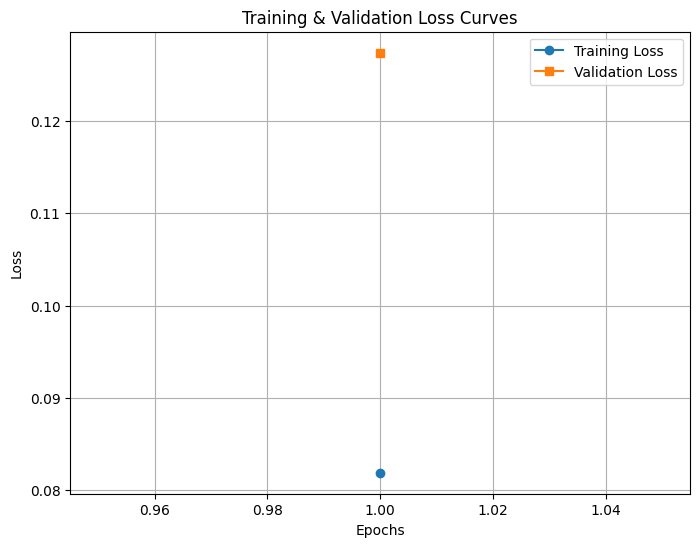

'\n# Plot training & validation accuracy\nplt.figure(figsize=(10, 5))\nplt.plot(train_acc, label="Training Accuracy")\nplt.plot(val_acc, label="Validation Accuracy")\nplt.xlabel("Epochs")\nplt.ylabel("Accuracy")\nplt.legend()\nplt.title("Training & Validation Accuracy Curve")\nplt.show()\n'

In [36]:
import matplotlib.pyplot as plt

print(f"train_loss: ", train_loss)
print(f"val_loss: ", val_loss)

# Ensure train_loss is a list
if isinstance(train_loss, float):
    train_loss = [train_loss]

# Ensure val_loss is a list (just a safety check)
if isinstance(val_loss, float):
    val_loss = [val_loss]

print("Processed train_loss:", train_loss)
print("Processed val_loss:", val_loss)

epochs = range(1, len(train_loss) + 1)  # Create epoch numbers

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Curves')
plt.legend()
plt.grid()
plt.show()


'''
# Plot training & validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy Curve")
plt.show()
'''